In [2]:
from irbasis_util.four_point_ph_view import *
from irbasis_util.internal import *
from irbasis_util.regression import *

# Implementation of Rohringer et al. () 2012)
def _delta(i, j):
    if i==j:
        return 1
    else:
        return 0

def _F_ph(U, beta, n, np, m):
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    r1 = nu + omega
    r2 = nu_p + omega
    tmp = 1. / (nu * r1 * r2 * nu_p)
    Fuu = (-0.25 * beta * (U**2) * (_delta(n,np) - _delta(m,0)) *
               (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    t1 = 0.125 * (U**3) * (nu**2 + r1**2 + r2**2 + nu_p**2) * tmp
    t2 = (3.0 / 16.0) * (U**5) * tmp
    t3 = (beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(0.5 * beta * U)))
              * (2 * _delta(nu, -nu_p - m) + _delta(m, 0)) *
              (1 + 0.25 * (U / r1)**2) * (1 + 0.25 * (U / r2)**2))
    t4 = (-beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(-0.5 * beta * U)))
              * (2 * _delta(nu, nu_p) + _delta(m, 0)) *
              (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    Fud = -U + t1 + t2 + t3 + t4
    return Fuu, Fud

def _G2_conn_ph(U, beta, n, np, m):
    Fuu, Fud = _F_ph(U, beta, n, np, m)
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    hU = 0.5 * U
    leggs_1 = nu * (nu + omega) * nu_p * (nu_p + omega)
    leggs_2 = ((hU**2 + nu**2) * (hU**2 + nu_p**2) *
                   (hU**2 + (nu + omega)**2) * (hU**2 + (nu_p + omega)**2))
    leggs = leggs_1 / leggs_2
    return leggs * Fuu + leggs * Fud

def _compute_Giw(beta, pole, s1, s2, r, n1, n2, boson_freq):
    iwn_f = lambda n : 1J * (2*n + 1) * numpy.pi / beta
    iwn_b = lambda n : 1J * (2 * n) * numpy.pi / beta
    if r == 0:
        return 1 / ((iwn_f(n1) + s1 * iwn_b(boson_freq) - pole) * (iwn_f(n2) + s2 * iwn_b(boson_freq) - pole))
    elif r == 1:
        n1_tmp = n1 + n2 * (-1) ** (s1+1)
        return 1 / ((iwn_b(n1_tmp) + s1 * iwn_b(boson_freq) - pole) * (iwn_f(n2) + s2 * iwn_b(boson_freq) - pole))
    elif r == 2:
        n_tmp = n2 + n1 * (-1)**(s1+1)
        return 1 / ((iwn_b(n_tmp) + s1 * iwn_b(boson_freq) - pole) * (iwn_f(n1) + s2 * iwn_b(boson_freq) - pole))

In [34]:
# Regression with multiple values of alpha
def ridge_complex_alphas(A, y, alphas):
    coeffs_alpha = []
    squared_errors_alpha = []
    for alpha in alphas:
        coeffs = ridge_complex(A, y, alpha)
        coeffs_alpha.append(coeffs)
        squared_errors_alpha.append(numpy.linalg.norm(y-numpy.dot(A, coeffs))**2)
    return coeffs_alpha, squared_errors_alpha

In [38]:
boson_freq = 10
Lambda = 10.0
beta = 5.0
U = 2.0
wmax = Lambda / beta

numpy.random.seed(100)
noise = 0.0001

In [39]:
#alpha = 1e-15
augmented = True
phb = FourPointPHView(boson_freq, Lambda, beta, 1e-5, augmented)
Nl = phb.Nl
whichl = Nl - 1
# build the sampling frequency structure
sp = phb.sampling_points_matsubara(whichl)
S = phb.normalized_S()
n_sp = len(sp)
prj = numpy.array(phb.projector_to_matsubara_vec(sp))[:, :, :, :, :, :] * S[None, :]
prj_mat = prj[:, :, :, :, :, :].reshape((n_sp, 3 * 2 * 2 * Nl * Nl))
# Build the check frequency structure
n1n2_check = []
niw = 100
niw_hf = 10000
wide_niw_check = numpy.hstack((range(-niw_hf, -niw, 500), range(-niw, niw, 10), range(niw, niw_hf, 500)))
for i, j in product(wide_niw_check, repeat=2):
    n1n2_check.append((i, j))
prj_check = numpy.array(phb.projector_to_matsubara_vec(n1n2_check))[:, :, :, :, :, :] * S[None, :]

Giwn = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in sp])
print ("adding noise")
noise_iwn = numpy.random.normal(loc=0.0, scale=noise, size=(len(sp)))
Giwn = noise_iwn + Giwn

adding noise


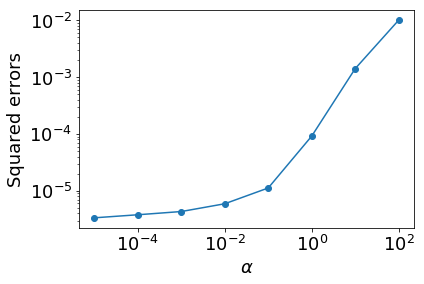

In [43]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
coeffs_alpha, se_alpha = ridge_complex_alphas(prj_mat, Giwn, alphas)
plt.plot(alphas, se_alpha, marker='o')
plt.xlabel(r'$\alpha$')
plt.ylabel('Squared errors')
plt.xscale('log')
plt.yscale('log')
#plt.legend(loc='best')

In [48]:
# OK, let us alpha = 0.1.
# An optimal value can be estimated by the elbow method (refer to the SpM paper by J. Otsuki et al.)
alpha_best = 0.1
coeffs = ridge_complex(prj_mat, Giwn, alpha_best).reshape((3, 2, 2, Nl, Nl))

In [49]:
Giwn_check = numpy.dot(prj_check.reshape((len(n1n2_check), 3 * 2 * 2 * Nl * Nl)),
                           (coeffs).reshape((3 * 2 * 2 * Nl * Nl)))
Giwn_check_ref = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in n1n2_check])

diff = numpy.amax(numpy.abs(Giwn_check - Giwn_check_ref))
print(numpy.amax(numpy.abs(Giwn_check - Giwn_check_ref)))
print(diff < 1e-3)

0.0002321895293677656
True


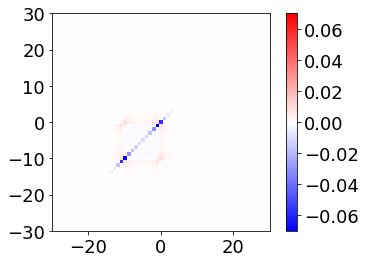

In [50]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

N = 30
#x = numpy.linspace(-N, N, 2*N+1)
x = numpy.arange(-N, N+1)
z = numpy.zeros((2*N+1, 2*N+1), dtype=float)

for i in range(2*N+1):
    for j in range(2*N+1):
        n = x[i]
        np = x[j]
        G2_conn_ph = _G2_conn_ph(U, beta, n, np, boson_freq)
        z[i,j] = G2_conn_ph.real

vrange = numpy.amax(numpy.abs(z))
plt.imshow(z.T, origin="lower", extent=(numpy.amin(x), numpy.amax(x), numpy.amin(x), numpy.amax(x)), cmap=cm.bwr, vmin=-vrange, vmax=vrange)
plt.colorbar()

#plt.legend(loc='best',shadow=True,frameon=False)

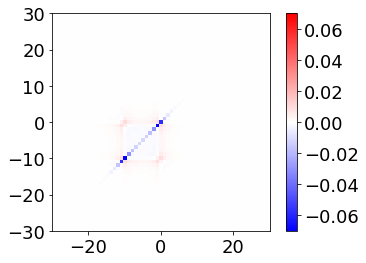

In [51]:
n1n2_check_2d = numpy.array([(x[i],x[j]) for i in range(2*N+1) for j in range(2*N+1)])
prj_check_2d = numpy.array(phb.projector_to_matsubara_vec(n1n2_check_2d))[:, :, :, :, :, :] * S[None, :]
Giwn_check = numpy.dot(prj_check_2d.reshape((len(n1n2_check_2d), 3 * 2 * 2 * Nl * Nl)),
                           (coeffs).reshape((3 * 2 * 2 * Nl * Nl)))
z_check = Giwn_check.real.reshape((2*N+1, 2*N+1))
vrange = numpy.amax(numpy.abs(z_check))
plt.imshow(z_check.T, origin="lower", extent=(numpy.amin(x), numpy.amax(x), numpy.amin(x), numpy.amax(x)), cmap=cm.bwr, vmin=-vrange, vmax=vrange)
plt.colorbar()